In [1]:
#Libraries for data wrangling
import pandas as pd
import numpy as np

#Libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Evaluation metrices
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,f1_score
from sklearn.model_selection import StratifiedKFold, KFold

#Machine learning libraries
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


#Outlier Handling
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split


#Feature engineering
from sklearn.impute import KNNImputer,SimpleImputer

#Feature scaling
from sklearn.preprocessing import RobustScaler

In [2]:
#weighted ensembling
import optuna
from functools import partial
from itertools import combinations
import random
import gc


In [3]:
def Draw_Score(P,T):
 plt.figure(figsize=(25,15))
 print(f'R-squared:{r2_score(T,P)} Mean squared error:{mean_squared_error(T,P)}' )
 plt.plot(np.array(T),label="Actual_values")
 plt.plot(P, label="Predicted_values")
 plt.ylabel('compressive_strength',fontsize=25)
 plt.title('Comparison')
 legend=plt.legend()
 plt.grid=True

In [4]:
def out_iqr(df , column):
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    median=df[column].median()
    #Repalcing outliers with median value
    df[column]=df[column].apply(lambda x: x if(x > lower and x<upper) else median)

In [5]:
#Reading the training dataset
train=pd.read_excel('dataset.xlsx').drop(['Compressive\nstrength tests', 'Elastic\nmodulus tests',
       'Flexural\nstrength tests', 'Splitting\ntensile strength tests'],axis=1)
target_col='Compressive\nstrength (f’c) (MPa)'
features=list(train.columns)
#drop row with all the features na.
train=train.dropna(how='all')

In [6]:
train.shape

(522, 15)

# EDA + FEATURE ENGINEERING

<AxesSubplot:>

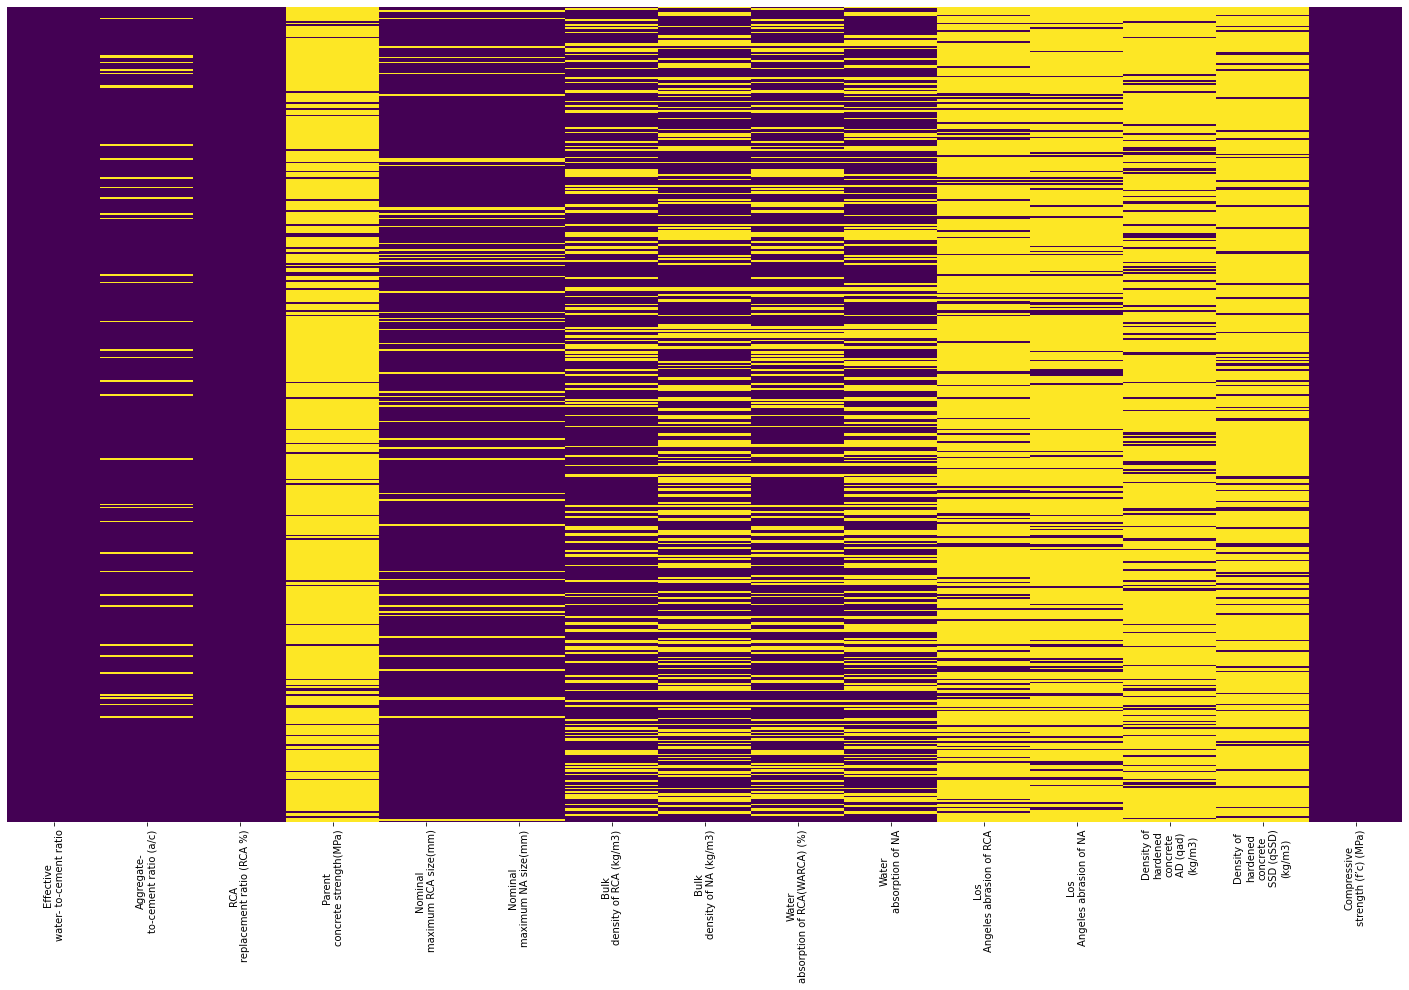

In [7]:
#Visualising na values
plt.figure(figsize=(25,15))
plt.xticks(rotation=45)
sns.heatmap(train.isnull(),cmap='viridis',yticklabels=False,cbar=False)
#The yellow lines represent the na values present in each feature

In [8]:
#No of rows with atleast one na values
print(train.isna().any(axis=1).sum()) 
#Seems like all the row got atleast one null value.

522


In [9]:
#Distrubtion of target features
fig=px.histogram(x=train[target_col],template='simple_white',color_discrete_sequence = ['#1192AA'])
fig.update_layout(
    xaxis_title="Compressive_Strength",
    yaxis_title="Frequency",
    showlegend = False,
    font = dict(
            size = 14
            ),    
    title={
        'text': "Compressive_Strength Distribution in Dataset",
        'y':0.95,
        'x':0.5
        }
)
fig.show()

In [10]:
#Filling the missing values using knn imputer
imputer=SimpleImputer(strategy='constant')
train=pd.DataFrame(imputer.fit_transform(train),columns=features)

<AxesSubplot:>

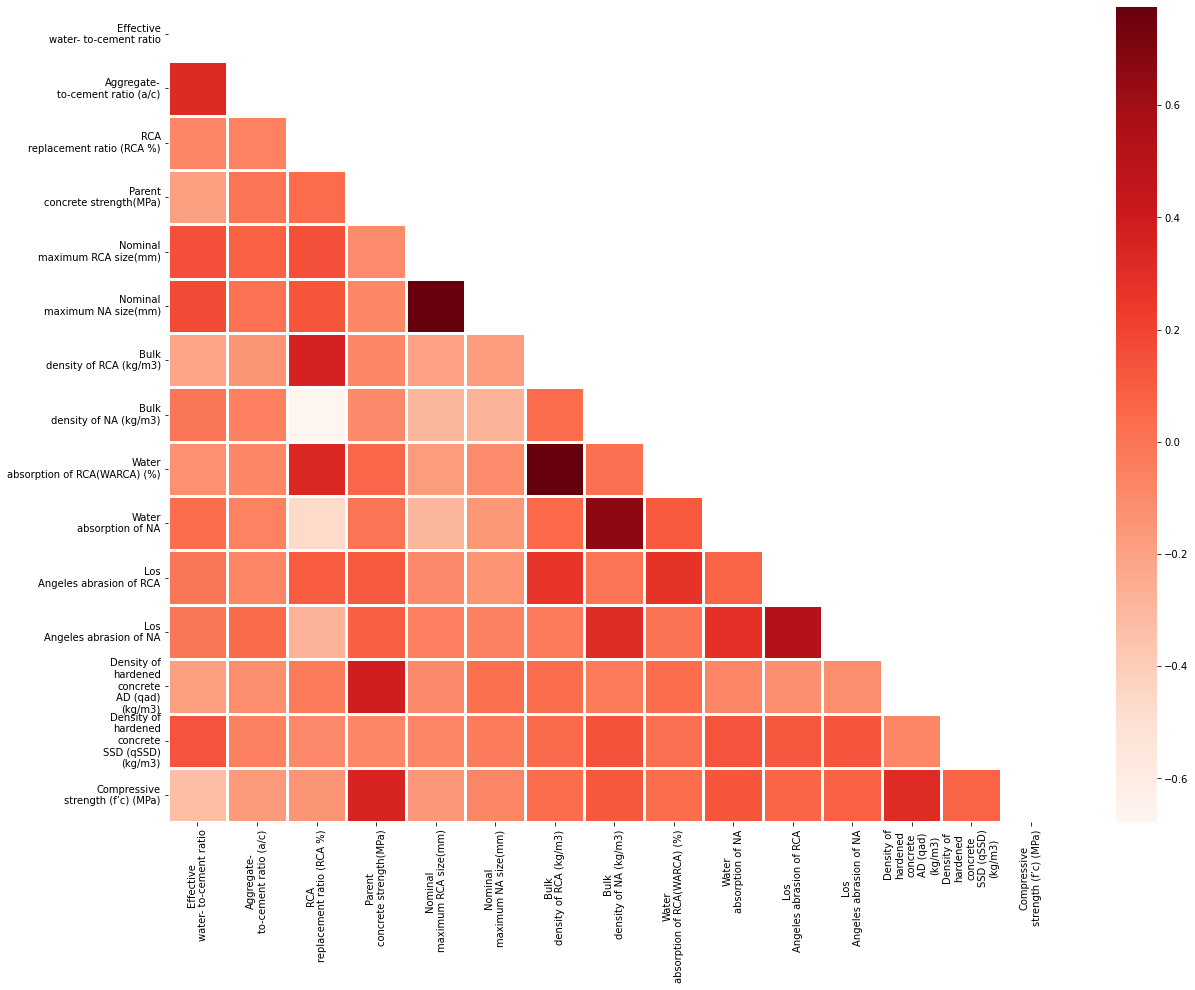

In [11]:
#Correlation between the features
fig, axes = plt.subplots(figsize=(20, 15))
mask=np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)]=True
sns.heatmap(train.corr(),mask=mask,linewidths=3,annot=False,cmap='Reds')
#target column and parent_concrete strength showing correlation.

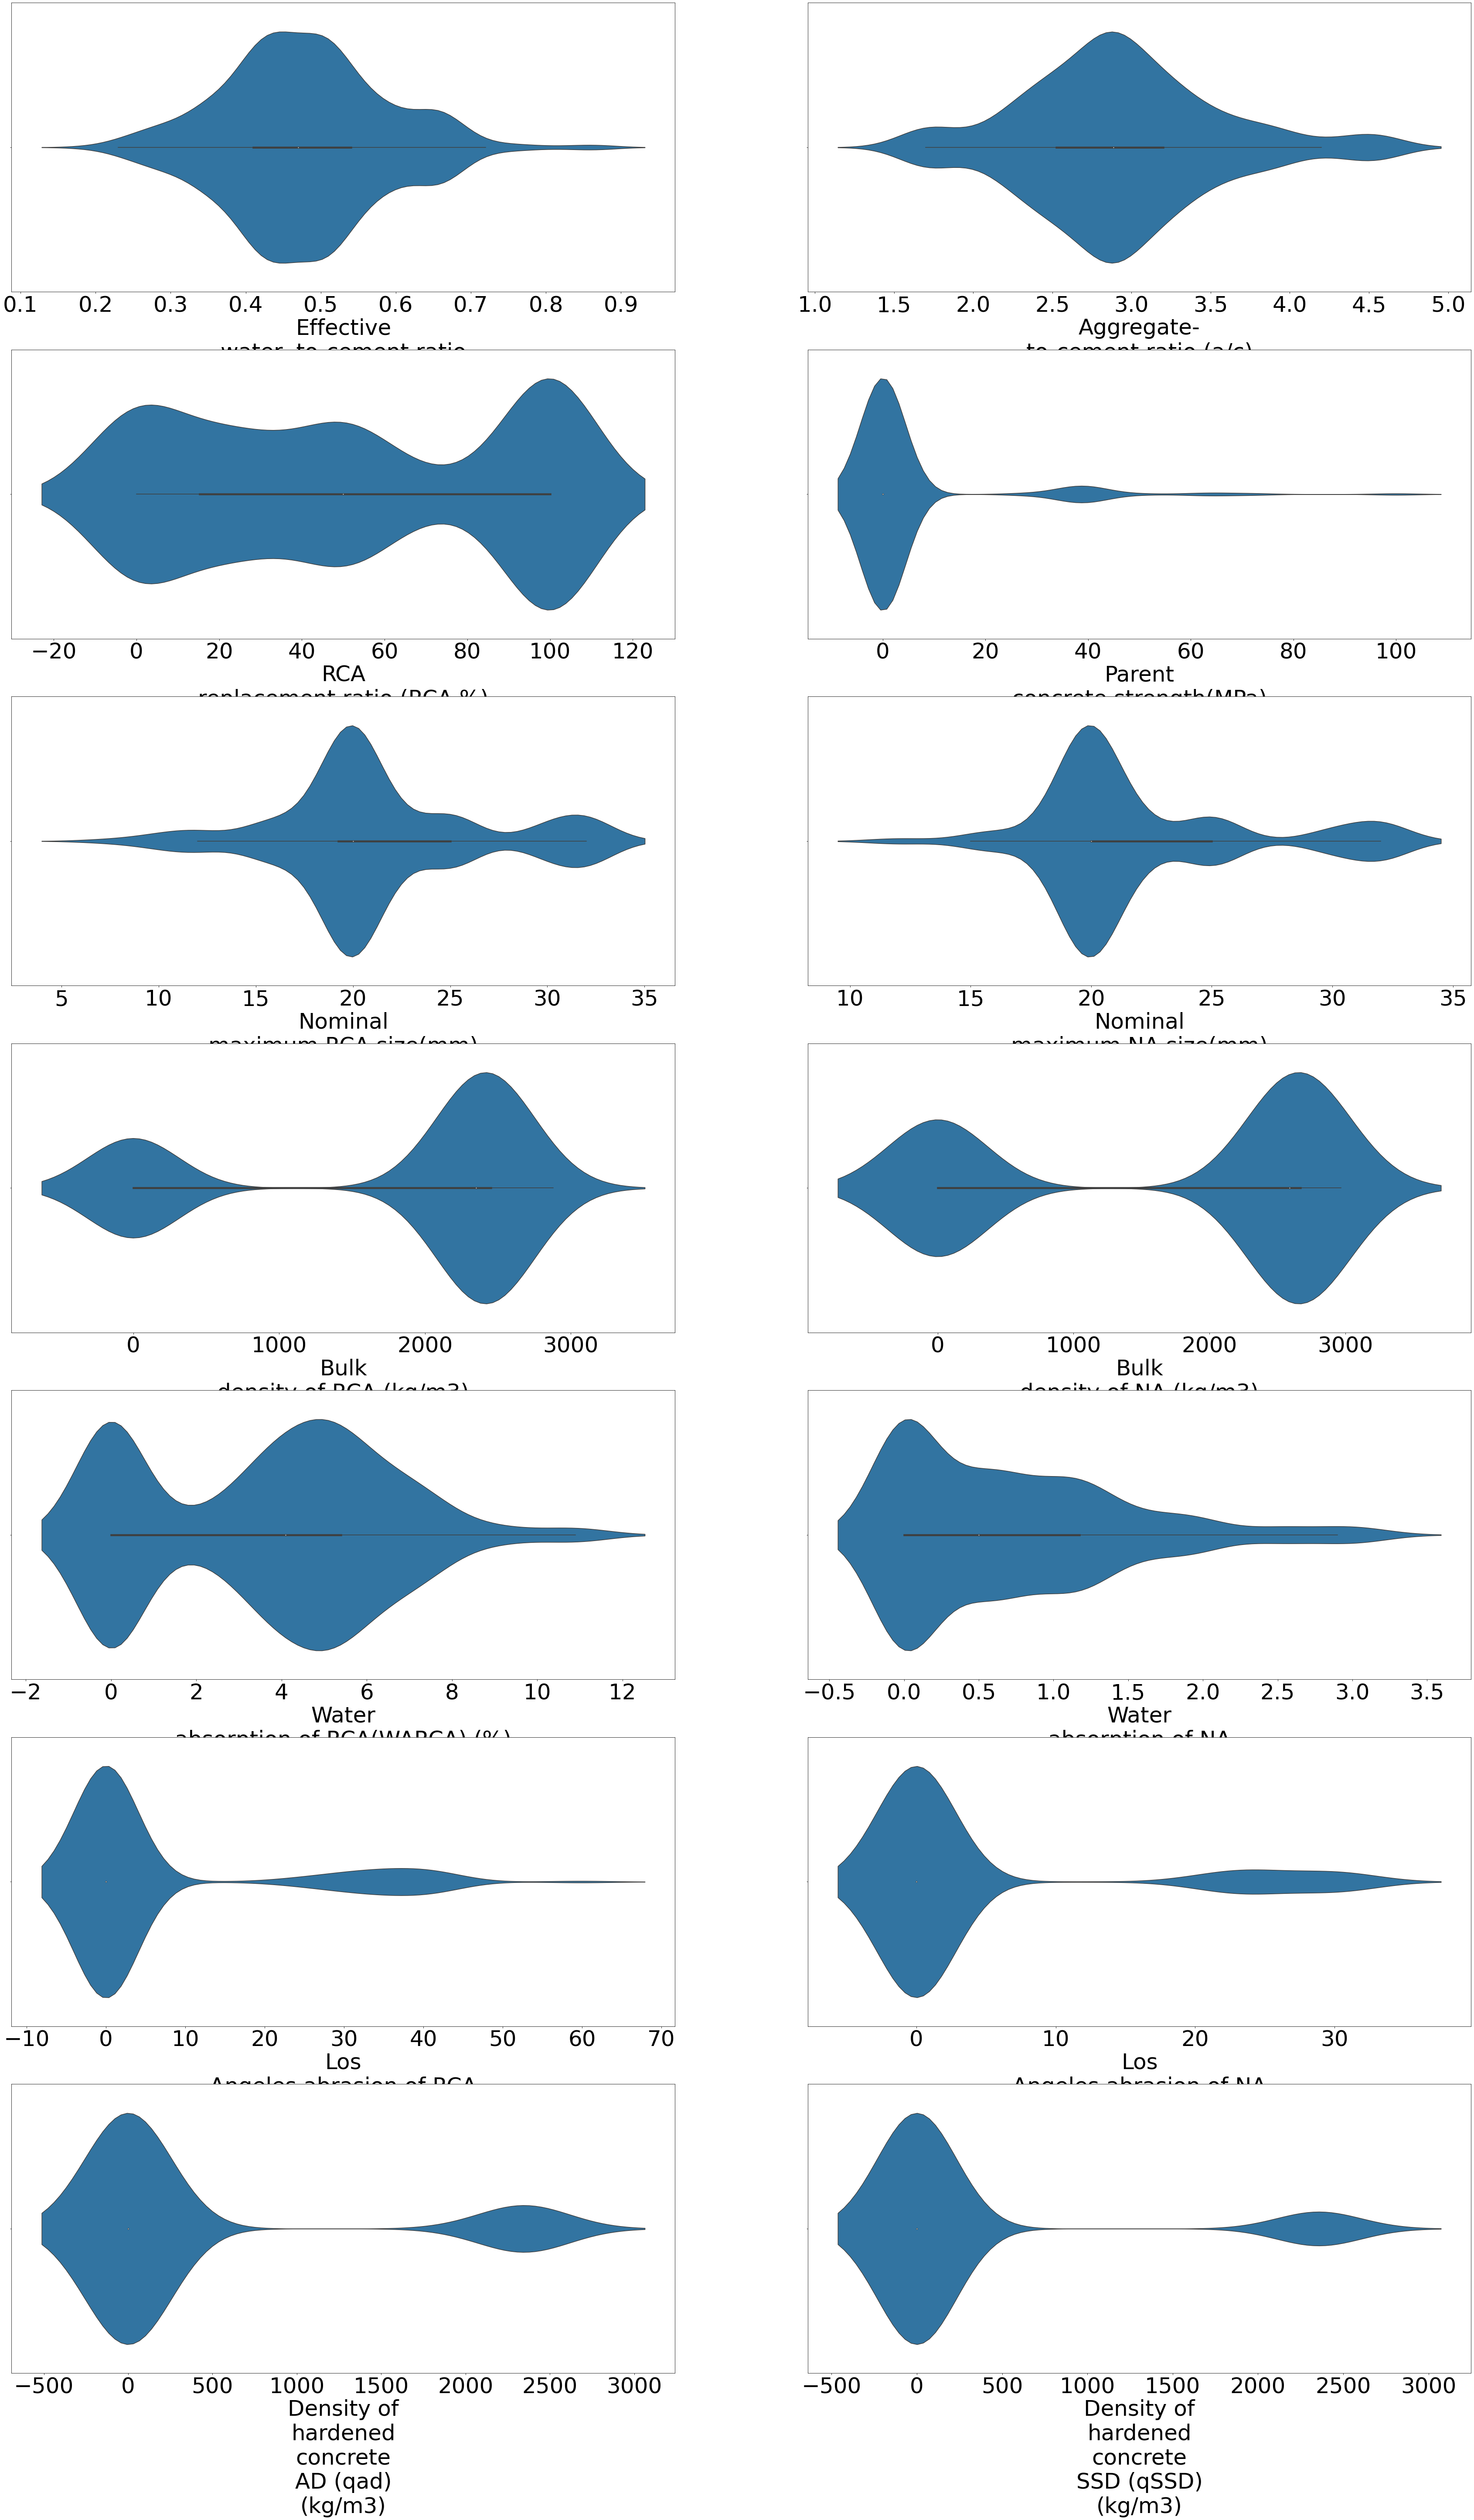

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(60, 100))
plt.rcParams.update({'font.size': 50})
for i,feature in enumerate(features):
    if feature!=target_col:
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        ax.yaxis.grid(True)
        sns.violinplot(x=train[feature], ax=ax,)

# Removing outliers

In [13]:
impute_column=['Aggregate-\nto-cement ratio (a/c)','RCA\nreplacement ratio (RCA %)','Nominal\nmaximum RCA size(mm)',
               'Nominal\nmaximum NA size(mm)','Water\nabsorption of RCA(WARCA) (%)']

In [14]:
#Removing the outliers
for f in impute_column:
    out_iqr(train,f)

In [15]:
#Defining the dependent and independent featurses
X_train=train.drop([target_col],axis=1)
y_train=train[target_col]
#We will using the training set for testing purpose.
X_test=X_train.copy()

In [16]:
#There are outliers for few features hence we will be using robust scaling.
#RobustScalers handles outliers
Col=features
Col.remove('Compressive\nstrength (f’c) (MPa)')
rs=RobustScaler()
X_train=pd.DataFrame(rs.fit_transform(X_train),columns=Col)
X_test=pd.DataFrame(rs.fit_transform(X_test),columns=Col)

In [17]:
#Box-cox transformation of Bulk density of RCA leads to better learning of models.
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
sc=MinMaxScaler()
transformer = PowerTransformer(method='box-cox')
X_train["bx_cx_"] = transformer.fit_transform(sc.fit_transform(X_train[['Bulk\ndensity of RCA (kg/m3)']])+1)
X_test["bx_cx_"] = transformer.transform(sc.transform(X_test[['Bulk\ndensity of RCA (kg/m3)']])+1)
X_train=X_train.drop(['Bulk\ndensity of RCA (kg/m3)'],axis=1)
X_test=X_test.drop(['Bulk\ndensity of RCA (kg/m3)'],axis=1)

#  models

In [18]:
#Defining all the models used for prediction.
#Hyperparameter were found with  bayesian optimisation using hyperplot
class Regressor:
    def __init__(self):
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        xgb_params = {
           'gamma':0.760,
            'learning_rate':0.1216,
            'max_depth':4,
            'n_estimators':208,
            'reg_lambda':0.002,
            'subsample':0.935,
            'base_score':0.5,
            'booster':'gbtree',
            'min_child_weight':0.2
        }  
        
        rf_params =  {
            'max_depth':19,
            'max_leaf_nodes':145,
            'max_samples':0.9998,
            'min_samples_leaf':1,
            'min_samples_split':2,
            'min_impurity_decrease':0,
            'n_estimators': 193
            
        }
        
       
        gdbt_params = {
            'n_estimators': 239,
            'learning_rate': 0.2165,
            'max_depth':4,
            'min_impurity_decrease':0,
            'subsample':0.9965
        }
        
        
        models = {
            'xgb':  XGBRegressor(**xgb_params),
            'gdbt': GradientBoostingRegressor(**gdbt_params),
            'rf' : RandomForestRegressor(**rf_params)
        }
        
        return models

In [19]:
class Splitter:
    def __init__(self, kfold=True, n_splits=5):
        self.n_splits = n_splits
        self.kfold = kfold

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
        else:
            raise ValueError(f"Invalid kfold: Must be True")

In [20]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=2000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-14, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = mean_absolute_error(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='minimize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [21]:
kfold = True
n_splits = 5
random_state_list = [42] 
regressor = Regressor()
test_predss = np.zeros((X_test.shape[0]))
oof_predss = np.zeros((X_train.shape[0]))
ensemble_score = []
weights = []
splitter = Splitter(kfold=kfold, n_splits=n_splits)
score_dict = dict(zip(regressor.models_name, [[] for _ in range(regressor.len_models)]))
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
    
    #Creating instance of object.
    regressor = Regressor()
    models = regressor.models
    
    
    test_preds = []
    oof_preds = []
    for name, model in models.items():
        model.fit(X_train_, y_train_)
        
        
        y_val_pred =model.predict(X_val).reshape(-1)
        test_pred = model.predict(X_test).reshape(-1)
        
        
        score= [r2_score(y_val, y_val_pred)]
        score_dict[name].append(np.mean(score))
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    

    optweights = OptunaWeights(random_state=42)
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    score = mean_absolute_error(y_val, y_val_pred)
    ensemble_score.append(score)
    weights.append(optweights.weights)
    

    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    oof_predss[X_val.index] = optweights.predict(oof_preds)
    
    gc.collect()
        
        

R-squared:0.9859794848413115 Mean squared error:2.988583042861126


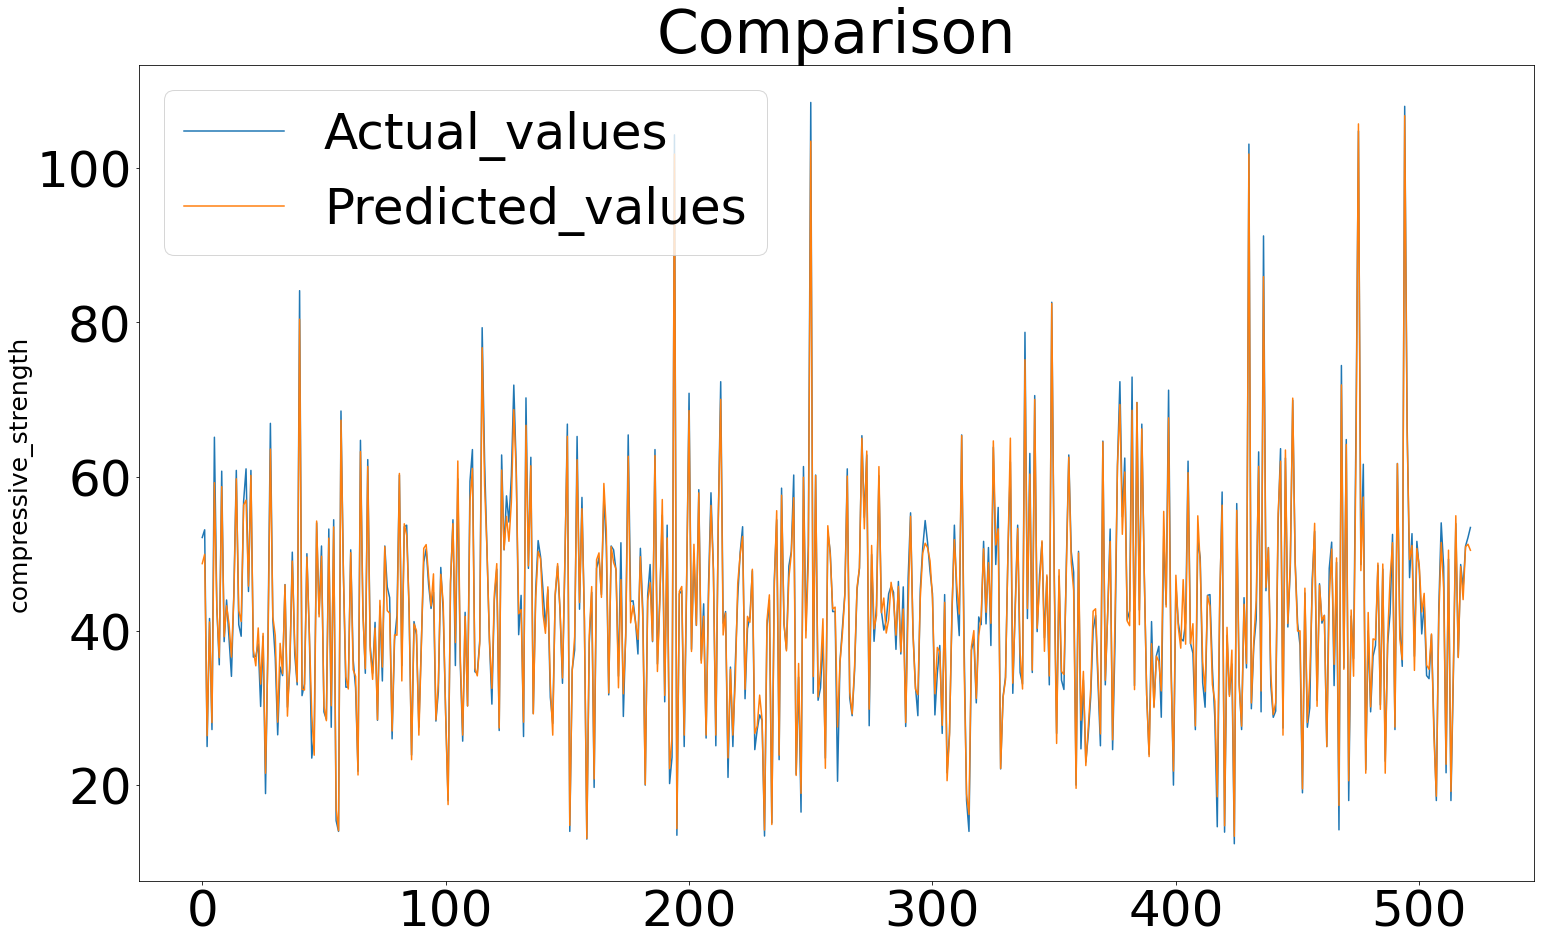

In [22]:
Draw_Score(test_predss,y_train)

In [23]:
score=pd.DataFrame(score_dict,index=['fold'+ str(i) for i in range(0,n_splits, 1)])
print(score.mean())#Average r^2 value for each model.

xgb     0.823072
gdbt    0.805523
rf      0.716649
dtype: float64


In [24]:
score

xgb      gdbt        rf
fold0  0.799198  0.761806  0.676706
fold1  0.835105  0.828944  0.791292
fold2  0.826416  0.809958  0.710122
fold3  0.778999  0.738761  0.576474
fold4  0.875642  0.888146  0.828652